<a href="https://colab.research.google.com/github/VfrMark/MNIST_mtm/blob/main/Marcos_Atividade_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste notebook será desenvolvido um classificador MNIST com 'data augmentation' das imagens de treinamento.

Este projeto faz parte de uma atividade avaliativa da disciplina MTM3587-08222 (20212) - Aprendizado da Máquina lecionada pelo Prof. Edson.

Aluno: Marcos Rosa - 18100695

#MNIST

Neste pequeno notebook ilustraremos a aplicação de alguns conceitos de Machine Learning relativas ao problema de classificação de dígitos. Devido ao tamanho do dataset, não é intenção do notebook fazer otimizações de modelos, mas tão somente ilustrar alguns conceitos tais como:

*   Visualização de imagens à partir de matrizes em escalas de cinza
*   SGDClassifier (sklearn)
*   GridSearch
*   Tópicos em classificação multiclasse

Bom aprendizado!




# Configurações iniciais


Inicialmente, vamos importar alguns módulos comuns e configurar o matplotlib para funcionar mais elegantemente, além de configurar um módulo para salvar figuras.

In [46]:
# Common imports
import numpy as np
import pandas as pd 
import os


# Para ajudar na reproducibilidade
# Aqui a seed é 42, mas não há nada de especial nisso
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id, format='png', dpi=600)

# MNIST

Vamos agora importar o [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), que um largo conjunto de dados que contém anotações à mão de dígitos, de 0 à 9. 

É um dataset muito utilizado para aprendizado, assim como referência quando se pretende testar novos algoritmos de classificação.



 Vamos precisar importar o conjunto de dados. O sklearn já vem com uma rotina para buscar alguns datasets públicos, como é caso do MNIST. Para isso vamos utilizar 'fetch_openml()' para buscar o nosso conjunto de dados.

<font color= '#5A35B6'>**Atenção:**</font>  A função `fetch_mldata()` está obsoleta desde o Scikit-Learn 0.20. Devemos, ao invés disso, utilizar o `fetch_openml()`. Observa que seguindo as boas práticas de ML, a nova função já retorna o MNIST de forma não ordenada, enquanto que `fetch_mldata()` retorna o conjunto de dados ordenados pelo rótulo. Poderá então haver diferenças dependendo da versão que você utilizar. Recomenda-se que você atualize a sua versão do sklearn.


In [47]:
#Importando dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

Vejamos o tipo dos dados que temos a nossa disposição

In [48]:
type(mnist)

sklearn.utils.Bunch

Esse tipo de dados é uma espécie de container implementada no Sklearn. Os elementos devem ser acessado através de "chaves" que dão acesso ao conjunto de dados. Para acessar as features, usamos a chave "data", ao passo que para acessar os rótulos usamos "target":

In [49]:
mnist["data"], mnist["target"]

(       pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
 0         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 1         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 2         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 3         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 4         0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 ...       ...     ...     ...     ...  ...       ...       ...       ...       ...
 69995     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 69996     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 69997     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 69998     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
 69999     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0   

Você poderia também acessar como se fosse um atributo do objeto mnist:

In [50]:
mnist.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.0,252.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vejamos as dimensões da matriz "mnist.data"

In [51]:
mnist.data.shape

(70000, 784)

Agora vamos instanciar as features do problemas em uma matriz X e os rótulos no vetor y

In [52]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Temos um total de 70000 instâncias e 784 features/características. Vamos agora tentar entender melhor do que se tratam essas 784 características.

Primeiramente, devemos lembrar que os nossos dados são 
<font color= '#5A35B6'>**imagens**</font>. Para ser mais preciso, as 784 representam as intesidades, na escala preto e branco, de cada pixel de uma imagem quadrada com 28px em cada dimensão. 

Note que 28*28 = 784.

Vamos agora pegar um dígito, redimensionar em 28 por 28 pixels e visualizar essa imagem.

A seguir, chamamos o "plt" do matplotlib, colocando como argumento três paramêmtros:

- A matriz que representa a imagem;

- O mapeamento de cores (color map - cmap). No nosso caso, usaremos inicialmente um esquema binário preto e branco;

- Método de interpolação: originalmente a nossa imagem tem dimensões 28X28 em pixels, ao passo que o matplotlib pode dispor a imagem em outras dimensões, requerendo uma técnica "interpolação" para preencher pixels faltando quando redimensionamos a imagem. Para essa finalidade, recomendo usar o método a seguir usando três técnicas: 'nearest', 'gaussian' e 'lanczos'. Em cada uma delas execute o código, que vai gerar uma imagem, após isso abra a imagem em outra aba e afaste (ctrl --) e aproxime (ctrl ++) a imagem para entender esse efeito da interpolação.



Saving figure some_digit_plot


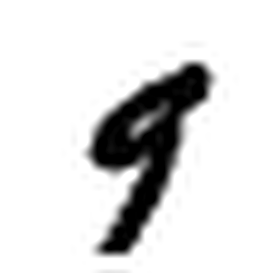

In [53]:
some_digit = X.iloc[36000].to_numpy()   #Antes estava X[3600] e não estava rodando.
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, 
           cmap = mpl.cm.binary,
           interpolation= 'lanczos')

plt.axis("off") #para desligar os eixos da imagem

save_fig("some_digit_plot")
plt.show()

Vejamos o rótulo:

In [54]:
y[36000]

9

Vamos agora definir uma função que servirá para plotar as imagens, que basicamente organiza o código que ilustramos anteriormente, podendo ser chamado várias vezes se quisermos.

In [55]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Agora vamos separa o nosso conjunto de treino e teste. Observe que não precisaríamos embaralhar os dados pois eles já vieram embaralhados!

Mas vamo embaralhar apenas que você não se esqueça desse detalhe muito importante.

Aqui estaremos utilizando 60000 imagens para treino e 10000 para teste.

In [56]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [57]:
#Embaralhemento 
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train.iloc[shuffle_index], y_train[shuffle_index]


# Multiclass classification

Agora vamos usar o conjunto de treinamento através de um esquema de validação cruzada para eleger o modelo mais indicado para o nosso problema. 

Antes disso faça um estudo sobre modelos lineares que usam Gradiente Descendente Estocástico (SGD):

- Faça uma leitura sobre assunto no [**guia do usuário**](https://scikit-learn.org/stable/modules/sgd.html#sgd) do sklearn. De acordo com o guia, esses modelos lineares são bem importantes para classificação de textos e processamento natural de linguagem (NLP);

- Dê uma olhada no [**SGDClassifier do sklearn**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier). Leia os parágrafos inciais da documemtanção até parte que inicia a descrição dos parâmetros da classe, preste atenção principalmente nos parâmetros: "loss", "penalty" e "alpha".

Vamos fazer uma otimização através dos seguintes parâmetros:

loss : ['hinge', 'log']

alpha: [1e-4,  1e-2,  1]

Pode-se incluir a penalização também, mas evitaremos muitos parâmetros pois o treinamento é demorado.

In [58]:
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline #Para criar um pipeline!
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ]) #O nosso modelo passará pelo std_scaler e depois pelo estimador

#Usaremos 10 epochs, por isso max_iter = 10 
#Cuidado, valores alto de max_iter fazem o algortirmo demorar
#Outros valores para max_iter ou random_state, vão alterar o resultado

param_grid = [{'estimator__loss' : ['hinge', 'log'],
               'estimator__alpha': [1e-4, 1e-2, 1],
               }] #grade de parâmetros para testar

"""É necessário colocar o prefixo estimator__ para indicar que os parâmetros 
serão aplicados ao estimador. Você poderia tentar otimizar o pré-processamento
dentro do pipeline também! Mas observa que muitos parâmetros tornam o processo
bem demora.
"""

#Quanto maior o verbose no GridSearch, mais detalhes sobre o processo
#n_jobs = -1 signifca o número de cores da máquina (-1 usa todos)
grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('estimator',
                                        SGDClassifier(max_iter=10,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'estimator__alpha': [0.0001, 0.01, 1],
                          'estimator__loss': ['hinge', 'log']}],
             verbose=10)

Vamos agora visualizar os resultados

In [59]:
results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                     pd.DataFrame(grid_search.cv_results_['std_test_score'], 
                                  columns=["Std"]),
                     pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                                  columns=["Score"])],axis=1)

results.sort_values("Score", ascending=False) #Ordenamento decrescente

,estimator__alpha,estimator__loss,Std,Score
0,0.0001,hinge,0.002276,0.911800
1,0.0001,log,0.002690,0.911317
2,0.0100,hinge,0.003303,0.895133
3,0.0100,log,0.002763,0.894883
4,1.0000,hinge,0.005083,0.863683
5,1.0000,log,0.006217,0.840233


<font color= '#5A35B6'>**Observações**</font> importantes:



* Fazendo uma análise preliminar, há indícios de que uma regularização l2 com alpha 0.0001 fornece as melhores respostas. Observa ainda que o modelo está indicado que está havendo subajuste (menor alpha, menos regularização), o que indica que deveríamos procurar um modelo mais complexo para a situação.

*   Outro fato importante de se observar é que não estipulamos o "score" no gridSearch e nesse caso o score será herdado do estimador. No nosso exemplo o SGDClassifier por padrão calcula a acurácia, então o score na tabela significa acurácia. 

Vamos agora treinar um modelo com os melhores parametros do GridSearch.

In [60]:
model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

model.set_params(**grid_search.best_params_) #Introduz no pipeline os parametros



Pipeline(steps=[('std_scaler', StandardScaler()),
                ('estimator', SGDClassifier(max_iter=10, random_state=42))])

In [61]:
#Treinando o modelo
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('estimator', SGDClassifier(max_iter=10, random_state=42))])

Vamos agora pegar um elemento do conjunto de teste para dar uma pequena espiada se o modelo está funcionando. 

<font color= '#5A35B6'>**Cuidado**</font>: Teoricamente não se deve usar o conjunto de teste até o final do processo. Então devemos utilizar ele agora. Mas se quisermos ser bem rigorosos, no final bastaria não considerar essa única instância que faríamos esse teste preliminar.

In [62]:
#Instanciando e treinando um digito em espcifico:
some_digit = X_test.iloc[0]
model.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


array([7], dtype=int8)

In [63]:
y_test.iloc[0]

7

O resultado foi o esperado? 

O SGD é treinado em um esquema OvR, de forma que cada classe tem um estimador associado. Dessa forma, cada estimador fornece um score correspondente a uma certa classe, de forma que o algoritmo rotula a nova instância com o estimador que obteve o maior score.

In [64]:
some_digit_scores = model.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


array([[-1151.02879743, -1556.65704299, -1625.00768203,  -723.7029964 ,
        -1224.37804869, -1266.90999103, -2350.40223502,   282.94034641,
        -1326.0511831 ,  -306.38372845]])

In [65]:
np.argmax(some_digit_scores)

7

In [66]:
model.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

Agora nós faremos uma coisa interessante: 

Vamos forçar o SGD a usar esquema OvO.

In [67]:
#classe que implementa OvO na força
from sklearn.multiclass import OneVsOneClassifier

#Vamos aumentar o número de iterações.
#Lembra que na técnica OvO há mais treinamentos mas pode ser interessante 
#quando o modelo sofre com a escala

model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 1000, random_state=42))
             ])

model.set_params(**grid_search.best_params_)
ovo_clf = OneVsOneClassifier(model)

Façamos uma validação cruzada para verificar o desempenho:

In [68]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ovo_clf, X_train, y_train, cv=5)

In [69]:
scores

array([0.91583333, 0.91516667, 0.91408333, 0.91916667, 0.91333333])

In [70]:
np.mean(scores)

0.9155166666666666

Vamos treinar no conjunto de dados

In [71]:
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([7], dtype=int8)

Como temos 10 classes ao todo, no esquema OvO treinamos um total de  $\displaystyle C_{10, 2} = \frac{10!}{(10-2)! 2! } = 45$ modelos.

In [ ]:
len(ovo_clf.estimators_)

Agora vamos preparar o nosso modelo para uma avaliação final no conjunto de teste.


In [ ]:
from sklearn.metrics  import confusion_matrix

In [ ]:
y_pred = ovo_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9254

#Agora é a sua vez

Agora você deve repetir o processo, mas utilizando uma etapa de pré-processamento chamando "data augmentation". No caso de imagens, essa técnica pode consistir de diversas metodologias, como: aumentar o número de instâncias de treinamento com rotações e translações das imagens. 

Nesse caso, a tua missão é treinar um novo modelo no MNIST utilizando translações no conjunto de treinamento. Fazendo isso, ensinamos o modelo a não esperar a figura centrada na imagem, podendo aumentar sua performance no teste. 

**Sua tarefa:**

- Crie uma função  para aumentar o conjunto de **treinamento**, de forma a fazer translações nas imagens. Após isso, você deve treinar o SGDClassifier nesse conjunto de dados aumentado.

- Teste o modelo no mesmo conjunto de teste que eu separei - isso é apenas um artifício didático para comparar o data augmentation, a partir do segundo teste a estimativa do erro de generalização deveria ser corrigida se quisermos obter uma estiva de performance!


Se você estiver com dificuldades, veja a solução do exercício 2 aqui nesse [notebook](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb) do A. Géron.

In [73]:
#Função que 'desloca' a imagem.

from scipy.ndimage.interpolation import shift

def data_augmentation(data, x, y):
    data = data.to_numpy()
    final_data = data.reshape((28, 28))
    shifted_data = shift(final_data, [y, x])
    return shifted_data.reshape([-1])

In [74]:
# Esse processo demora muito pois não esta nem um pouco otimizado
# Mas não consegui pensar em um outro modo para fazer data augmentation
# "do zero". Por isso fiz com apenas 1/3 do conjunto de treino.
''', (-3, 0), (0, 2), (0, -3)'''

X_train_augmented = X_train.copy()
y_train_augmented = y_train.copy()

for x, y in ((2, 0), (-3, 0)):
    for i in range(20000):

        image = X_train.iloc[[i]]
        aug_image = data_augmentation(image, x, y)
        aug_image_to_append = pd.DataFrame(aug_image, columns=[image.index[0]], index=X_train.columns).transpose()

        X_train_augmented = X_train_augmented.append(aug_image_to_append)
        y_train_augmented = y_train_augmented.append(y_train.iloc[[i]])

"""X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)"""

'X_train_augmented = np.array(X_train_augmented)\ny_train_augmented = np.array(y_train_augmented)'

In [75]:
#Ver tamanho do dataset antes e depois o processo de data augmentation

print(X_train.shape)
print(X_train_augmented.shape)

(60000, 784)
(100000, 784)


In [76]:
#Ver também os rótulos

print(y_train.shape)
print(y_train_augmented.shape)

(60000,)
(100000,)


##Treinando modelo SGDClassifier com conjunto pós data augmentation

In [77]:
#Encontrando os melhores parâmetros com GridSearch

aug_pipe = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

aug_param_grid = [{'estimator__loss' : ['hinge', 'log'],
               'estimator__alpha': [1e-4, 1e-2, 1],
               }]

aug_grid_search = GridSearchCV(aug_pipe, aug_param_grid, cv=5, verbose=10, n_jobs=-1)
aug_grid_search.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('estimator',
                                        SGDClassifier(max_iter=10,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'estimator__alpha': [0.0001, 0.01, 1],
                          'estimator__loss': ['hinge', 'log']}],
             verbose=10)

In [78]:
#Instanciando modelo final com melhores parâmetros e esquema OvO.

aug_model_final = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

aug_model_final.set_params(**aug_grid_search.best_params_)
aug_ovo_clf = OneVsOneClassifier(aug_model_final)

In [79]:
#Treinando o modelo no conjunto de treino pós data augmentation

aug_ovo_clf.fit(X_train_augmented, y_train_augmented)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

OneVsOneClassifier(estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('estimator',
                                              SGDClassifier(max_iter=10,
                                                            random_state=42))]))

In [80]:
#Predizer os rótulos do conjunto de teste

aug_y_pred = aug_ovo_clf.predict(X_test)

In [81]:
#Valor de acurácia dos dois modelos treinados, um no conjunto inicial 
#e outro no conjunto pós data augmentation

print(f"Acurácia do modelo pré data augmentation: {accuracy_score(y_test, y_pred)}")
print(f"Acurácia do modelo pós data augmentation: {accuracy_score(y_test, aug_y_pred)}")

Acurácia do modelo pré data augmentation: 0.9254
Acurácia do modelo pós data augmentation: 0.9133


Observamos que mesmo após o processo de data augmentation esse modelo, nesse contexto específico, retornou uma acurácia levemente inferior.